In [1]:
options(tidyverse.quiet = TRUE) 
library(tidyverse, warn.conflicts = FALSE)

library(badr)
load_julia_package()

Loaded julia package 'bad' successfully.



# Finding Optimal Two-Stage Designs

## Optimisation under uncertainty

### Prior choice

Start by defining the standard parameters.

In [2]:
alpha <- .05
beta  <- .2
p0    <- .2
p1    <- .4

Define uniform prior (maximum entropy, Beta(1,1)), then the subjective prior and update it with 4/10 out of assumed pilot trial. Finally robustify the informative prior with the maximum entropy one.

In [3]:
# non-informative component
noninformative        <- Beta(1, 1)
# informative prior component
informative           <- Beta_mu_sd(.35, .1)
# update with pilot data
informative_plus_data <- update(informative, 4, 10)
# combine with non-informative and cap upper tail
pragmatic             <- (0.2*noninformative + 0.8*informative_plus_data) <= 0.7

In [4]:
tbl_priors <- tibble(
        p                 = seq(0, 1, .001),
        informative = density(informative, p),
        `informative + data` = density(informative_plus_data, p),
        pragmatic         = density(pragmatic, p)
    ) %>%
    mutate(
        pragmatic = ifelse(abs(p - 0.7) == min(abs(p - 0.7)), NA_real_, pragmatic)
    ) %>%
    pivot_longer(-p, names_to = 'prior') %>%
    mutate(
        prior = factor(prior, levels = c(
                "informative",  "informative + data", "pragmatic"
            )
        )
    )

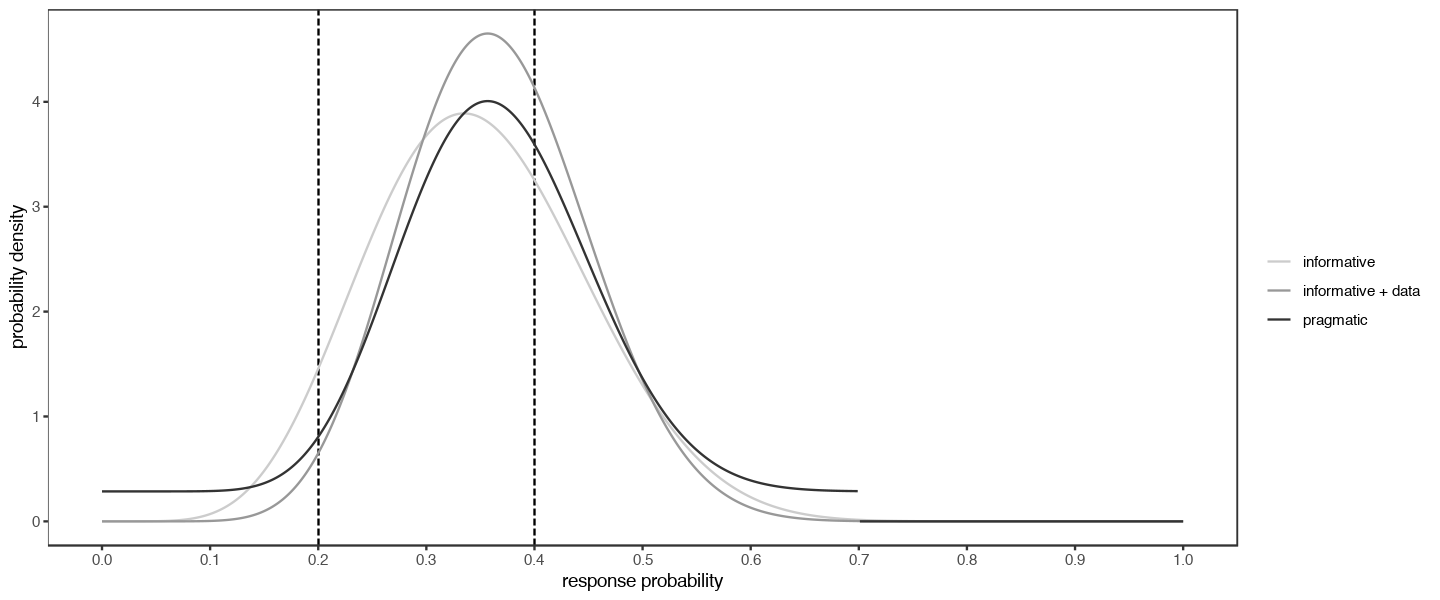

In [5]:
# plot
options(repr.plot.width = 12, repr.plot.height = 5)

ggplot(tbl_priors) +
    aes(p, value) +
    geom_vline(xintercept = c(p0, p1), color = 'black', linetype = 'longdash') +
    geom_line(aes(color = prior)) +
    scale_color_grey('', start = .8, end = .2) +
    scale_x_continuous('response probability', breaks = seq(0, 1, .1)) +
    scale_y_continuous('probability density') +
    theme_bw() +
    theme(
        panel.grid = element_blank()
    )


In [6]:
ggsave("optimisation-under-uncertainty-prior-choice.pdf", width = 7, height = 3)

In [7]:
design_uniform <- Problem(
        minimise(SampleSize(noninformative)),
        Power(noninformative %|% p0) <= alpha,
        Power(noninformative %|% p1) >= 1 - beta,
        label = 'non-informative'
    ) %>%
    optimise_design()

design_pragmatic <- Problem(
        minimise(SampleSize(pragmatic)),
        Power(noninformative %|% p0) <= alpha,
        Power(noninformative %|% p1) >= 1 - beta,
        label = 'pragmatic'
    ) %>%
    optimise_design()

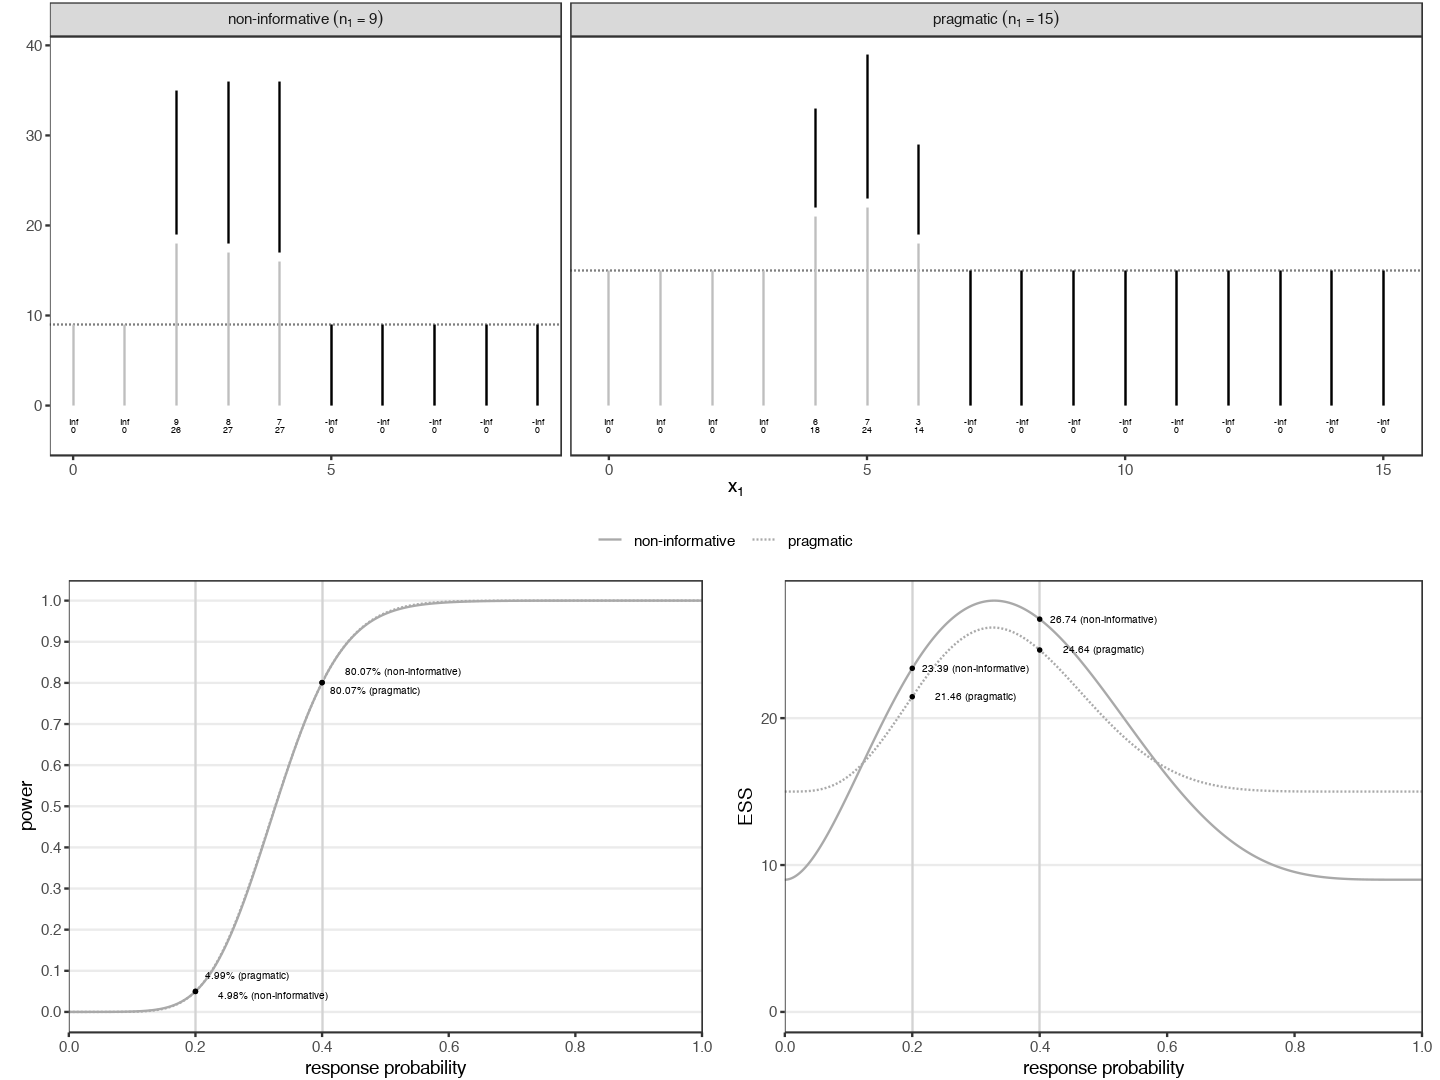

In [8]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(
    design_uniform, design_pragmatic,
    annotations = c(p0, p1)
)

In [9]:
ggsave("optimisation-under-uncertainty-prior-choice-designs.pdf", width = 7, height = 7)

### Power constraints

First, the minimal clinically relevant value for the response probability is defined before comparing the desings minimising expected sample size under the quantile approach, the point alternative and the expected power approach.

In [10]:
mcr <- 0.3

In [11]:
p        <- seq(0, 1, .01)
quantile <- function(prior, prob) {
    uniroot(
        function(p) cdf(prior, p) - prob, 
        interval = c(.01, .99), 
        tol = sqrt(.Machine$double.eps)
    )$root
}

In [12]:
design_p1 <- Problem(
        minimise( SampleSize(pragmatic) ),
        Power(noninformative %|% p0) <= alpha,
        Power(noninformative %|% p1) >= 1 - beta,
        label = 'p = 0.4'
    ) %>%
    optimise_design()

In [13]:
design_ep <- Problem(
        minimise( SampleSize(pragmatic) ),
        Power(noninformative %|% p0)  <= alpha,
        Power(pragmatic >= mcr) >= 1 - beta,
        label = 'EP'
    ) %>%
    optimise_design()

In [14]:
design_quantile <- Problem(
        minimise( SampleSize(pragmatic) ),
        Power(noninformative %|% p0)  <= alpha,
        Power(noninformative %|% quantile(pragmatic >= mcr, .33)) >= 1 - beta,
        label = 'quantile'
    ) %>%
    optimise_design()

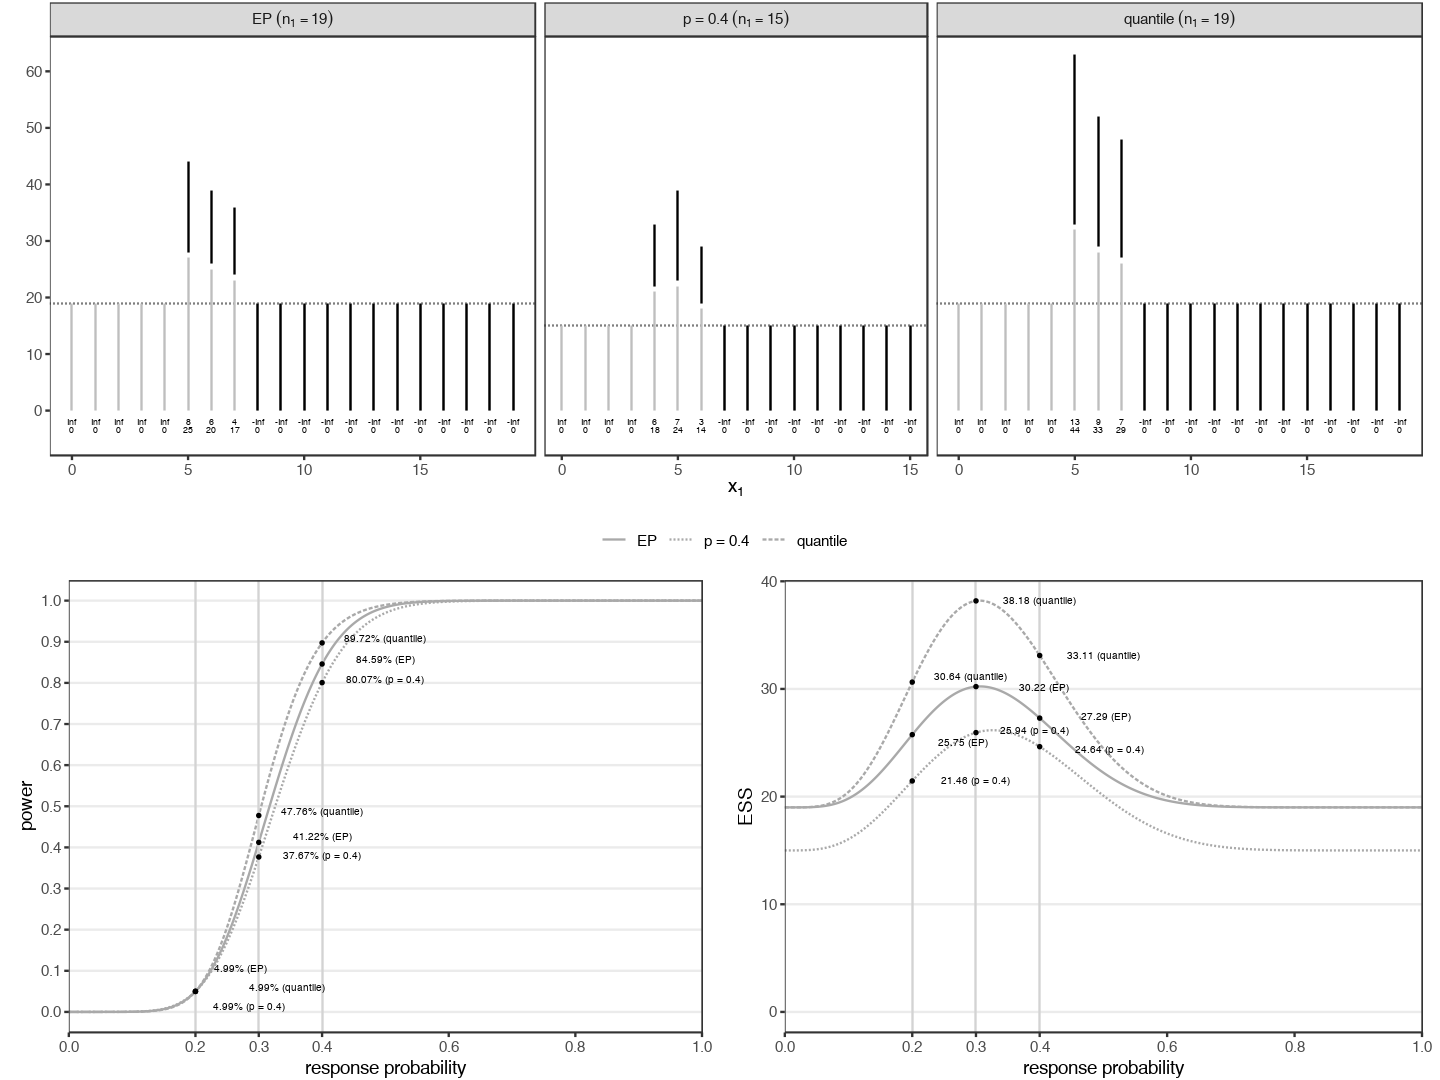

In [15]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(
    design_p1, design_ep, design_quantile,
    annotations = c(p0, mcr, p1)
)

In [23]:
ggsave("optimisation-under-uncertainty-power-constraints.pdf", width = 7, height = 7)

### Power at MRV under Expected Power for varying priors

Here, the influence of the informative prior component of the resulting design is investgated by varying the initial prior standard deviation and mean.

In [ ]:
tbl_designs <- expand_grid(
        mu = seq(.1, .8, by = .05),
        sd = seq(.05, .25, by = .05)
    ) %>%
    mutate(
        prior = map2(mu, sd, function(mu, sd) {
            (0.2*Beta(1,1) + 0.8*update(Beta_mu_sd(mu, sd), 4, 10)) <= 0.7
        }),
        a = map_dbl(prior, ~JuliaCall::field(JuliaCall::field(.@jprior, "priors")[2], "a")),
        b = map_dbl(prior, ~JuliaCall::field(JuliaCall::field(.@jprior, "priors")[2], "b")),
        design = map(prior, function(prior) {
            print(prior)
            Problem(
                minimise(SampleSize(prior)),
                Power(prior %|% p0)  <= alpha,
                Power(prior >= mcr) >= 1 - beta
            ) %>%
                optimise_design(verbosity = 0)
        })
    )

print(tbl_designs, n = 10)

In [ ]:
# plot
options(repr.plot.width = 12, repr.plot.height = 5)

tbl_designs %>%
    mutate(
        data = map(design, function(design) {
            tibble(
                power = probability_to_reject(design, .3)
            )
        })
    ) %>%
    unnest(data) %>%
    ggplot(aes(mu, sd)) +
    geom_raster(aes(fill = power)) +
    scale_fill_gradient(low = 'white', high = 'black', limits = c(0, 1)) +
    coord_cartesian(expand = FALSE) +
    labs(x = 'informative prior mean', y = 'informative prior standard deviation') +
    theme_bw() +
    theme(
        legend.position = 'right'
    )

In [ ]:
ggsave("optimisation-under-uncertainty-power-vs-prior-parameters.pdf", width = 7, height = 3)

### Utility based approach

Start by defining the individual components of the utility score.

In [18]:
# expected sample size
ess   <- SampleSize(pragmatic)

# maximal type one error rate
mtoer <- Power(pragmatic %|% p0)
# expected type one error rate
etoer <- Power(pragmatic <= mcr)
# expected power
epow  <- Power(pragmatic >= mcr)

# probability of success
pos   <- (1 - cdf(pragmatic, mcr)) * epow
# probability of a type one error
potoe <- cdf(pragmatic, p0) * etoer

In [20]:
# resolve for optimal design under pragmatic prior for expected power constraint
design_initial <- Problem(
        minimise(ess),
        (mtoer <= alpha) %>% conditional(c(.001, .5)),   # impose additional conditional error rate constraints
                                                         # to make optimisation faster
        (epow  >= 1 - beta) %>% conditional(c(.5, .999)),
        label = 'initial design'
    ) %>%
    optimise_design()

Make sure that the new formulation results in the same design

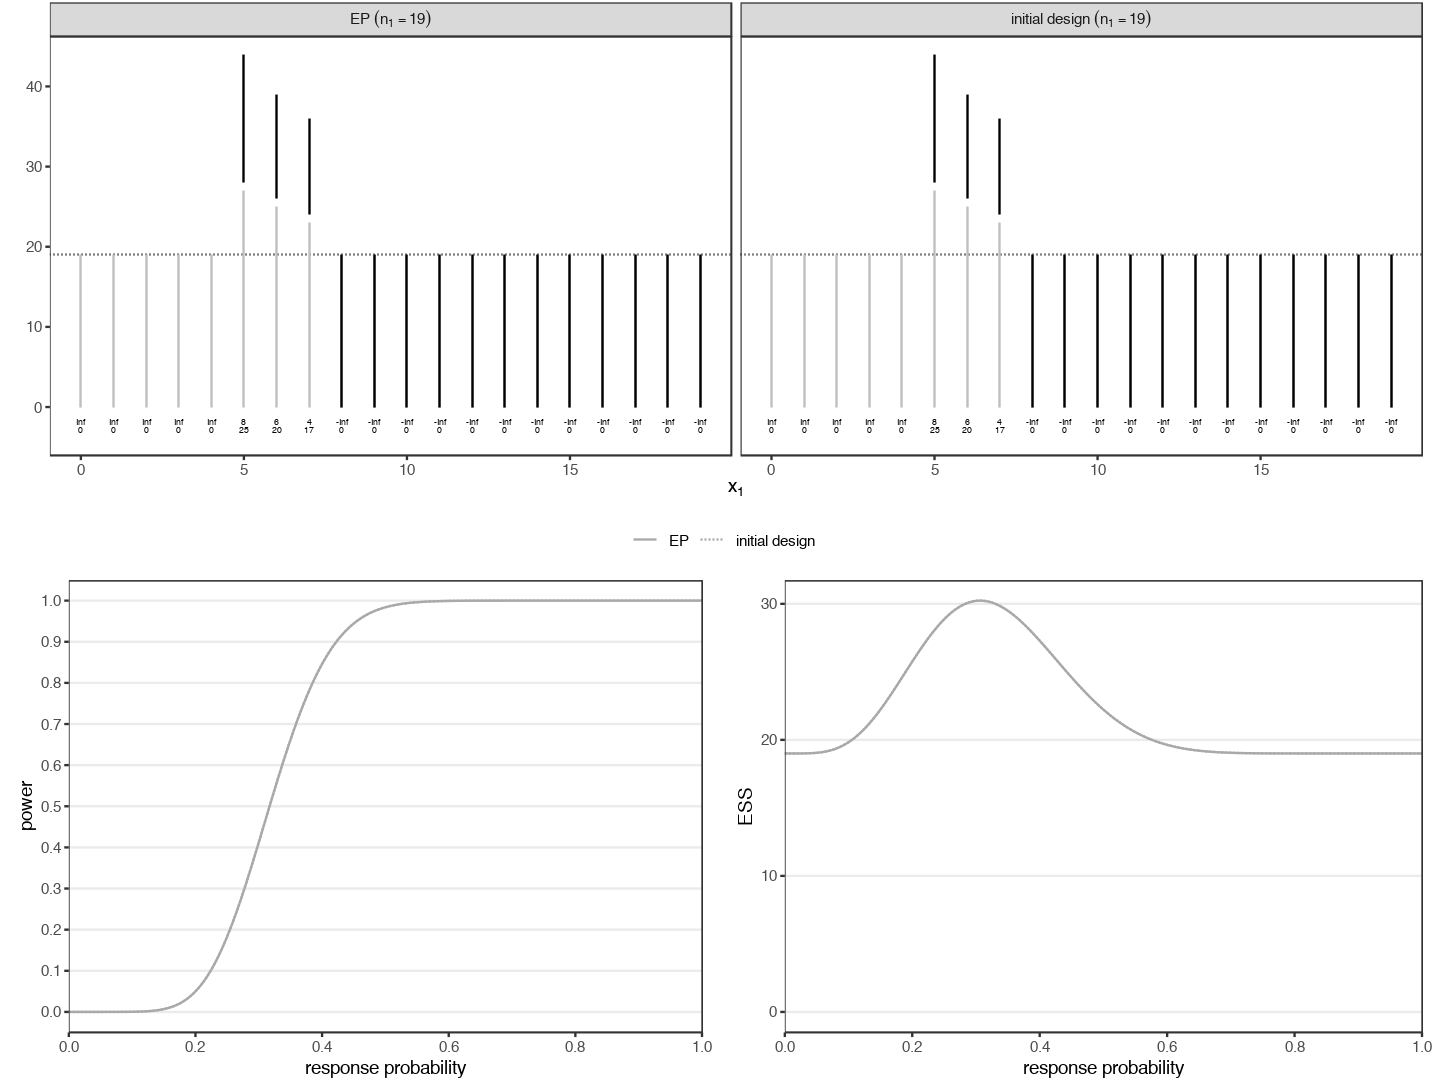

In [21]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_compare_designs(
    design_ep, design_initial
)

In [22]:
# define function to find utility-maximising design given $\lambda=(\lambda_{+,+},\lambda{+,-})$
f <- function(lambda) Problem(
        maximise(lambda[1]*pos - lambda[2]*potoe - ess),
        (mtoer <= 4*alpha)    %>% conditional(c(.001, .5)),    # relax type one error rate constraintr
        (epow  >= 1 - 2*beta) %>% conditional(c(.5, .999)),    # relax power constraint
        n1values = 10:30,    # make sure that the search space is still large enough even though the 
                             # constraints are so liberal
        nmax     = 70
    ) %>%
    optimise_design(verbosity = 0)

In [23]:
# define function to measure the maximal difference in power between two designs
delta <- function(design1, design2) {
    p <- seq(0, 1, .01)
    return( 100 * max( abs(
        probability_to_reject(design1, p) - probability_to_reject(design2, p)
    ) ) )
}

In [35]:
# evaluate the difference from the initial design on a grid of lambda values
# exploit the fact the we know the rough relative size of lambda++ and lambda+- from \alpha and \beta
tbl_grid <- expand_grid(
        w   = seq(.05, .2, length.out = 7),
        fct = seq(750, 1750, length.out = 7)
    ) %>%
    mutate(
        lambda_tp      = w * fct,
        lambda_fp      = (1 - w) * fct,
        optimal_design = map2(lambda_tp, lambda_fp, ~f(c(.x, .y))),
        delta          = map_dbl(optimal_design, ~delta(., design_initial))
    )

print(tbl_grid, n = 10)

# A tibble: 49 x 6
       w   fct lambda_tp lambda_fp optimal_design delta
   <dbl> <dbl>     <dbl>     <dbl> <list>         <dbl>
 1 0.05   750       37.5      712. <Design>        24.3
 2 0.05   917.      45.8      871. <Design>        24.3
 3 0.05  1083.      54.2     1029. <Design>        24.3
 4 0.05  1250       62.5     1188. <Design>        25.8
 5 0.05  1417.      70.8     1346. <Design>        25.8
 6 0.05  1583.      79.2     1504. <Design>        24.4
 7 0.05  1750       87.5     1662. <Design>        24.2
 8 0.075  750       56.3      694. <Design>        16.2
 9 0.075  917.      68.8      848. <Design>        16.2
10 0.075 1083.      81.2     1002. <Design>        16.2
# … with 39 more rows


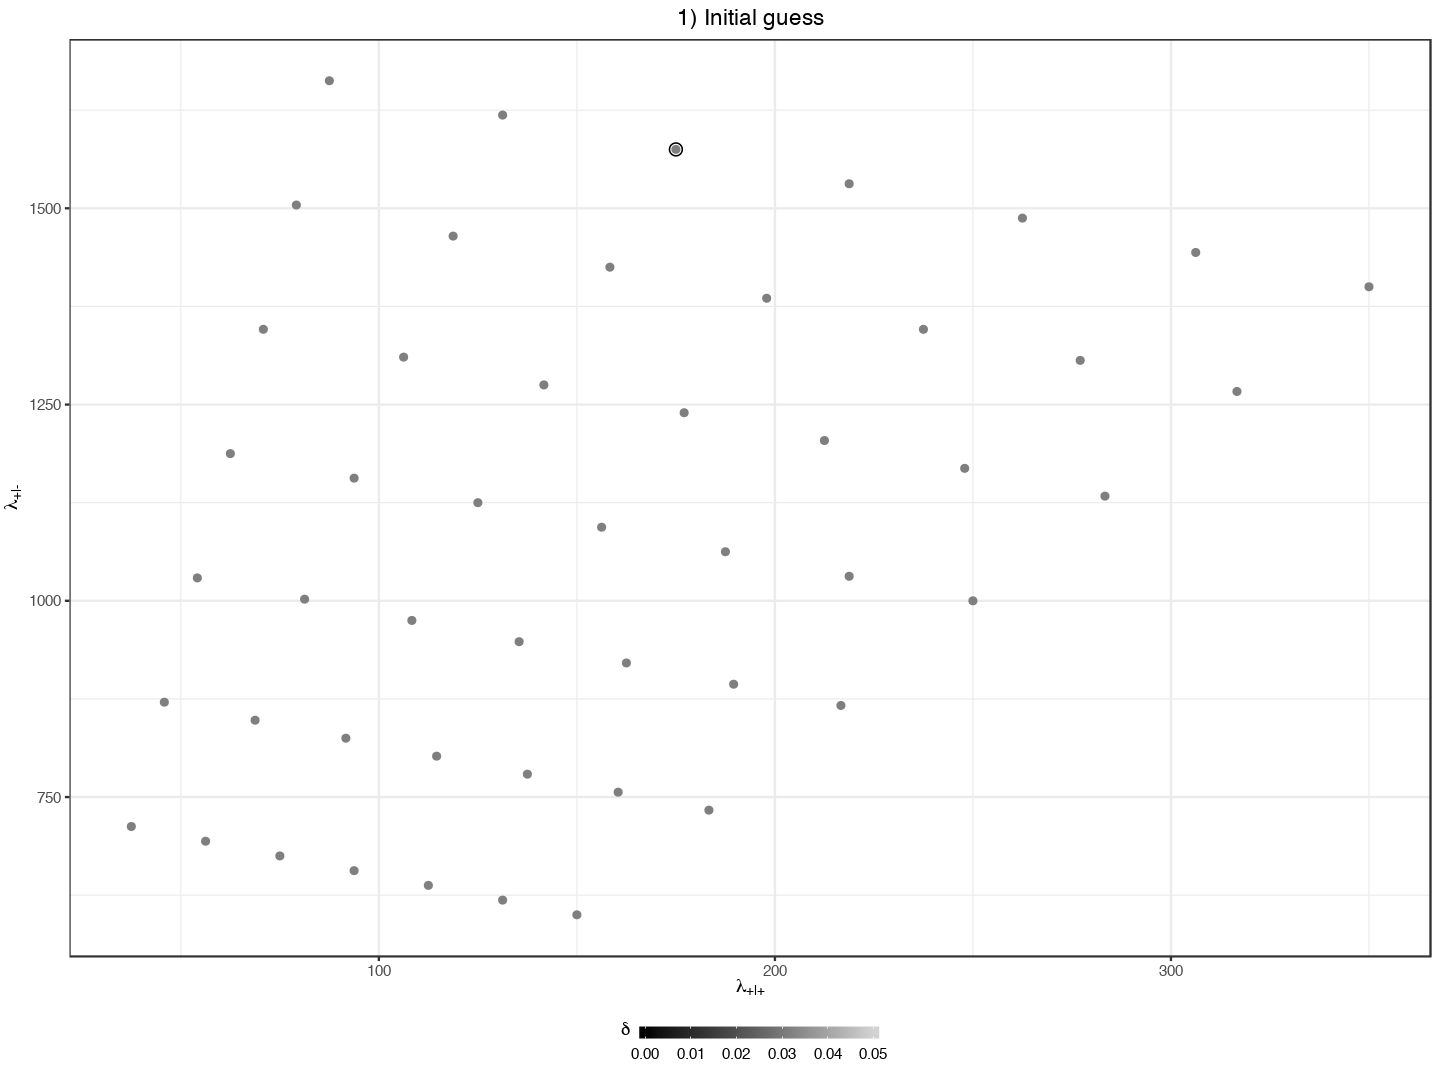

In [36]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_initial_guess <- ggplot(tbl_grid) +
    aes(lambda_tp, lambda_fp) +
    geom_point(shape = 1, size = 3, data = filter(tbl_grid, delta == min(delta))) +
    geom_point(aes(color = delta/100)) +
    scale_color_gradient(expression(delta), low = 'black', high = 'lightgray',
                         limits = c(0, .05)) +
    scale_x_continuous(expression(lambda['+|+'])) +
    scale_y_continuous(expression(lambda['+|-'])) +
    ggtitle('1) Initial guess', ) +
    theme_bw() +
    theme(
        plot.title   = element_text(hjust = .5, face = 'bold'),
        legend.title = element_text(vjust = 1),
        legend.position = 'bottom',
        legend.key.width = unit(2, 'lines'),
        legend.key.height = unit(.5, 'lines')
    )

plot_initial_guess

Refine the search by a local Nelder-Mead optimisation around the best combination of $\lambda$ found on the grid. 
Nelder-Mead is sensitive to scaling, so one needs to guess the problem scale first (difference in marginal paramters corresponding to unit change in objective).

In [27]:
initial_values <- filter(tbl_grid, delta == min(delta)) %>%
    {c(.$lambda_tp, .$lambda_fp)}

print(c(lambda_tp = initial_values[1], lambda_fp = initial_values[2]))

lambda_tp lambda_fp 
    112.5     125.0 


In [ ]:
design_init <- f(initial_values)

# difference in objective from initial design for given lambda + (a, b), lambda - (a, b) averaged
# to guess scale for Nelder-Mead
diff <- function(a, b) {
    (delta(design_init, f(initial_values + c(a, b))) + 
     delta(design_init, f(initial_values - c(a, b)))
    )/2
}

diff(80, 0)
diff(0, 200)

parscale <- c(80, 200)

Set everything up for Nelder-Mead and saving the optiomisation trace.

In [ ]:
# this is the table to save the optimisation trace to
tbl_opt_trace <- tibble(
    i         = integer(0),
    lambda_tp = numeric(0),
    lambda_fp = numeric(0),
    delta     = numeric(0)
)

# the counter keeps track of function invocations of the optimiser
counter <- function() {
    i <- 1
    function() {
        res <- i
        i <<- i + 1
        return(res)
    }
}
cntr <- counter()

# wrap the delta function such that the counter is updated each call and the 
# parameter configuration is stored in the trace table
h <- function(lambda) {
    step <- tibble(
        i         = cntr(),
        lambda_tp = lambda[1],
        lambda_fp = lambda[2],
        delta     = delta(design_0, f(lambda))
    )
    tbl_opt_trace <<- bind_rows(tbl_opt_trace, step)
    return(step$delta)
}

In [ ]:
# run the actual optimisation
res <- optim(
    initial_values,
    h,
    control = list(
        trace    = 10,
        parscale = parscale, # parameter scale determined earlier
        fnscale  = 10, # we need to scale the objective since the 
                       # parscale corresponds to a differenc of 10, not 1
        abstol   = .000001,
        reltol   = 0.,
        maxit    = 50,
        REPORT   = 1
    )
)

In [ ]:
# plot
options(repr.plot.width = 12, repr.plot.height = 9)

plot_nelder_mead <- ggplot(tbl_opt_trace) +
    aes(lambda_tp, lambda_fp) +
    geom_point(shape = 1, size = 3, data = filter(tbl_grid, delta == min(delta))) +
    geom_point(shape = 4, size = 3, data = tibble(lambda_tp = res$par[1], lambda_fp = res$par[2], delta = res$value)) +
    geom_point(aes(color = delta/100)) +
    geom_text(aes(label = label), size = 2.5, data = tibble(
            lambda_tp = res$par[1],
            lambda_fp = res$par[2] - 30,
            label     = sprintf("%.1f / %.1f", res$par[1], res$par[2])
        )
    ) +
    scale_color_gradient(expression(delta), low = 'black', high = 'lightgray') +
    scale_x_continuous(expression(lambda['+|+'])) +
    scale_y_continuous(expression(lambda['+|-'])) +
    ggtitle('2) Nelder-Mead', ) +
    theme_bw() +
    theme(
        plot.title      = element_text(hjust = .5, face = 'bold'),
        legend.title    = element_text(vjust = 1),
        legend.position = 'bottom',
        legend.key.width = unit(2, 'lines'),
        legend.key.height = unit(.5, 'lines')
    )

plot_nelder_mead

In [ ]:
# combine both plots
options(repr.plot.width = 12, repr.plot.height = 9)

cowplot::plot_grid(plot_initial_guess, plot_nelder_mead)

In [ ]:
ggsave("optimisation-under-uncertainty-matched-utility-trace.pdf", width = 7, height = 3.5)

In [ ]:
design_matched       <- f(res$par)
design_matched@label <- 'matched utility'

In [ ]:

plot_compare_designs(
    design_initial, design_matched,
    annotations = c(p0, mcr)
)

In [ ]:
ggsave("optimisation-under-uncertainty-matched-utility-design.pdf", width = 7, height = 7)

In [ ]:
utility <- res$par[1]*pos - res$par[2]*potoe - ess

evaluate(utility, design_initial)
evaluate(utility, design_matched)

In [ ]:
design_case_a <- f(c(333, res$par[2]))
design_case_a1@label <- 'A'

design_case_b <- f(c(res$par[1], 300))
design_case_b@label <- 'B'

In [ ]:
plot_compare_designs(
    design_matched, design_case_a, design_case_b,
    annotations = c(p0, mcr)
)

In [ ]:
ggsave("optimisation-under-uncertainty-matched-utility-cases.pdf", width = 7, height = 7)